In [1]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

[ca-ws:1413677] mca_base_component_repository_open: unable to open mca_accelerator_rocm: libamdhip64.so.6: cannot open shared object file: No such file or directory (ignored)


Let's use the same material definition as the existing pincell depletion example 

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in `z` assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at $-59\ cm$ so that the initial condition of $k_{eff} \sim 1$ is satisfied. 

Filling the `msr` cell with a universe is the requirement to set up a geometrical reactivity controller.

In [3]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
# set initial borated water level to -59 cm 
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
root = openmc.Universe(cells=[fuel, gap, clad, msr])
# Define overall geometry
geometry = openmc.Geometry(root)

In [5]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.IndependentSource(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell at the interface between the borated water and helium cells.

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

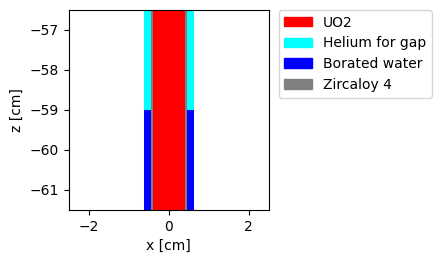

In [6]:
# Create plot
colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
root.plot(width=(5, 5), origin=(0,0,-59), pixels=(200, 200), basis='xz', color_by='material', colors=colors, legend=True)

Let's now build and run a standard depletion calculation, increasing the thermal power to $100\ kW$. The results will be used as the reference to compare with MSR capabilities:

In [7]:
chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
uo2.volume = pi * fuel_or.r**2 * height
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 1.0e5  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Pu239 from /home/lorenzo/nuclear_data/endfb80_h

       83/1    0.93272    0.98137 +/- 0.00474
       84/1    1.00376    0.98168 +/- 0.00468
       85/1    1.00235    0.98195 +/- 0.00463
       86/1    1.06873    0.98309 +/- 0.00471
       87/1    0.98181    0.98308 +/- 0.00465
       88/1    0.93439    0.98245 +/- 0.00463
       89/1    0.96467    0.98223 +/- 0.00457
       90/1    0.93916    0.98169 +/- 0.00455
       91/1    0.98893    0.98178 +/- 0.00449
       92/1    1.00864    0.98211 +/- 0.00445
       93/1    0.97983    0.98208 +/- 0.00440
       94/1    0.93801    0.98155 +/- 0.00437
       95/1    0.97341    0.98146 +/- 0.00432
       96/1    0.97888    0.98143 +/- 0.00427
       97/1    0.97509    0.98136 +/- 0.00422
       98/1    0.98592    0.98141 +/- 0.00418
       99/1    0.97668    0.98135 +/- 0.00413
      100/1    1.03354    0.98193 +/- 0.00412
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 se

[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000.0
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59386
        2/1    0.69696
        3/1    0.77062
        4/1    0.86882
        5/1    0.92647
        6/1    1.00861
        7/1    0.96018
        8/1    0.99117
        9/1    1.03898
       10/1    0.95815
       11/1    1.01929
       12/1    0.92974    0.97452 +/- 0.04477
       13/1    0.97763    0.97556 +/- 0.02587
       14/1    0.94831    0.96875 +/- 0.01952
       15/1    1.02163    0.97932 +/- 0.01845
       16/1    1.01315    0.98496 +/- 0.01609
       17/1    1.03485    0.99209 +/- 0.01535
       18/1    1.00738    0.99400 +/- 0.01343
       19/1    0.98837    0.99337 +/- 0.01186
       20/1    1.01030    0.99507 +/- 0.01074
       21/1    0.9

       47/1    0.99144    0.97584 +/- 0.00657
       48/1    0.99985    0.97647 +/- 0.00642
       49/1    0.91960    0.97501 +/- 0.00642
       50/1    0.98924    0.97537 +/- 0.00627
       51/1    0.99762    0.97591 +/- 0.00614
       52/1    0.95463    0.97540 +/- 0.00601
       53/1    0.99833    0.97594 +/- 0.00590
       54/1    0.99572    0.97639 +/- 0.00578
       55/1    0.98690    0.97662 +/- 0.00565
       56/1    0.98701    0.97685 +/- 0.00553
       57/1    0.96785    0.97665 +/- 0.00542
       58/1    0.97402    0.97660 +/- 0.00530
       59/1    1.03840    0.97786 +/- 0.00535
       60/1    0.96112    0.97753 +/- 0.00525
       61/1    0.99225    0.97781 +/- 0.00515
       62/1    0.95890    0.97745 +/- 0.00507
       63/1    0.97827    0.97747 +/- 0.00497
       64/1    0.99717    0.97783 +/- 0.00489
       65/1    0.95295    0.97738 +/- 0.00482
       66/1    0.93231    0.97657 +/- 0.00480
       67/1    0.93756    0.97589 +/- 0.00477
       68/1    0.96434    0.97569 

Let's store the depletion results for a later comparison.

In [8]:
# Open results file
ref_results = openmc.deplete.Results("depletion_results.h5")

Here we want to set a `ReactivityController` that is capable to keep $k_{eff}$ close to its initial value $(\sim 1.00 )$ during the whole depletion time, by dynamically increasing the quantity of borated water that acts as moderator and compensates for the neutrons capture of the fission products build-up. The `msr` cell that we previously set up and filled with an universe containing borated water and helium gas, can translate up and down, increasing and decreasing the borated water cell volume, respectively. 

The `ReactivityController` algorithm will run a `search_for_keff` at every depletion time-step to find the optimal cell translation coefficient that fulfils the target condition.  

To add a reactivity control, we need to add the `add_reactivity_control` method from the integrator instance, where we specify at minimum the cell to where apply the control, the type of control parametrization (in this case a cell translation along the `z-axis`), the bracket to restrict the `search_for_keff` interval and finally the bracket limit that should cover the total allowed range of excursion of the regulating system.   

In [9]:
# We need to re-instanciate the operator and the integrator 
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_reactivity_control(msr, 'translation', 
                    axis = 2, bracket = [-2, 2],
                    bracket_limit = [-100,100])
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.58547
        2/1    0.71045
        3/1    0.74808
        4/1    0.88430
        5/1    0.90487
        6/1    0.95028
        7/1    0.99179
        8/1    0.97392
        9/1 

/home/lorenzo/openmc/openmc/openmc/search.py:226: UserWarning: f(a) and f(b) must have different signs
  warn(f'{e}')
/home/lorenzo/openmc/openmc/openmc/deplete/reactivity_control.py:262: UserWarning: Search_for_keff returned values below or above target. Trying to iteratively adapt bracket...
  warn(


        3/1    0.83630
        4/1    0.92312
        5/1    0.90162
        6/1    0.96418
        7/1    0.99691
        8/1    1.05798
        9/1    0.98462
       10/1    0.95518
       11/1    1.07666
       12/1    1.00073    1.03869 +/- 0.03797
       13/1    1.04812    1.04184 +/- 0.02215
       14/1    0.94277    1.01707 +/- 0.02930
       15/1    0.95029    1.00372 +/- 0.02633
       16/1    1.02034    1.00649 +/- 0.02168
       17/1    1.03240    1.01019 +/- 0.01869
       18/1    0.98982    1.00764 +/- 0.01639
       19/1    1.01689    1.00867 +/- 0.01449
       20/1    0.96123    1.00393 +/- 0.01380
       21/1    0.96847    1.00070 +/- 0.01289
       22/1    1.04051    1.00402 +/- 0.01223
       23/1    1.07111    1.00918 +/- 0.01238
       24/1    0.97511    1.00675 +/- 0.01171
       25/1    0.99291    1.00582 +/- 0.01094
       26/1    0.99264    1.00500 +/- 0.01027
       27/1    1.02378    1.00610 +/- 0.00971
       28/1    0.98844    1.00512 +/- 0.00921
       29/1

/home/lorenzo/openmc/openmc/openmc/search.py:226: UserWarning: f(a) and f(b) must have different signs
  warn(f'{e}')
/home/lorenzo/openmc/openmc/openmc/deplete/reactivity_control.py:262: UserWarning: Search_for_keff returned values below or above target. Trying to iteratively adapt bracket...
  warn(


        2/1    0.68967
        3/1    0.75954
        4/1    0.81401
        5/1    0.80377
        6/1    0.91266
        7/1    0.82685
        8/1    0.80841
        9/1    0.82951
       10/1    0.84476
       11/1    0.96262
       12/1    0.92437    0.94350 +/- 0.01912
       13/1    0.87333    0.92011 +/- 0.02586
       14/1    0.87459    0.90873 +/- 0.02154
       15/1    0.87291    0.90156 +/- 0.01816
       16/1    0.87190    0.89662 +/- 0.01563
       17/1    0.90517    0.89784 +/- 0.01327
       18/1    0.86772    0.89408 +/- 0.01209
       19/1    0.98275    0.90393 +/- 0.01452
       20/1    0.86896    0.90043 +/- 0.01345
       21/1    0.86873    0.89755 +/- 0.01250
       22/1    0.95075    0.90198 +/- 0.01224
       23/1    0.88318    0.90054 +/- 0.01135
       24/1    0.89154    0.89989 +/- 0.01053
       25/1    0.91715    0.90104 +/- 0.00987
       26/1    0.86728    0.89893 +/- 0.00947
       27/1    0.88841    0.89832 +/- 0.00892
       28/1    0.97587    0.90262 

/home/lorenzo/openmc/openmc/openmc/search.py:226: UserWarning: f(a) and f(b) must have different signs
  warn(f'{e}')
/home/lorenzo/openmc/openmc/openmc/deplete/reactivity_control.py:262: UserWarning: Search_for_keff returned values below or above target. Trying to iteratively adapt bracket...
  warn(


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.65634
        2/1    0.75629
        3/1    0.93018
        4/1    0.94274
        5/1    0.97550
        6/1    0.99172
        7/1    0.95820
        8/1    0.94347
        9/1    0.96336
       10/1    1.10363
       11/1    0.99558
       12/1    1.07778    1.03668 +/- 0.04110
       13/1    0.97215    1.01517 +/- 0.03203
       14/1    1.07597    1.03037 +/- 0.02728
       15/1    0.98517    1.02133 +/- 0.02298
       16/1    1.01886    1.02092 +/- 0.01877
       17/1    0.97652    1.01458 +/- 0.01708
       18/1    0.95533    1.00717 +/- 0.01654
       19/1    1.06734    1.01386 +/- 0.01605
       20/1    0.94791    1.00726 +/- 0.01580
       21/1    1.04288    1.01050 +/- 0.01465
       22/1    0.99672    1.00935 +/- 0.01342
       23/1    0.95077    1.00484 +/- 0.01

Looking at the output, we  can notice that `search_for_keff` went off target, the method iteratively adapts it. 

Let's compare the results:

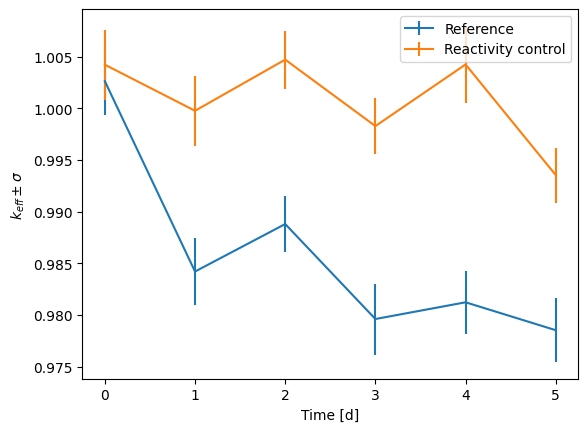

In [10]:
results = openmc.deplete.Results("depletion_results.h5")

time, ref_keff = ref_results.get_keff(time_units='d')
_, keff = results.get_keff(time_units='d')

plt.errorbar(time, ref_keff[:, 0], ref_keff[:, 1], label="Reference")
plt.errorbar(time, keff[:, 0], keff[:, 1], label="Reactivity control")
plt.legend()
plt.xlabel('Time [d]')
plt.ylabel(r'$k_{eff} \pm \sigma$')
plt.legend()
plt.show()

As we can see, $k_{eff} \sim 1$ is kept (within statistical uncertainity). This is achieved through the raise of the water level, as we can see in the following:

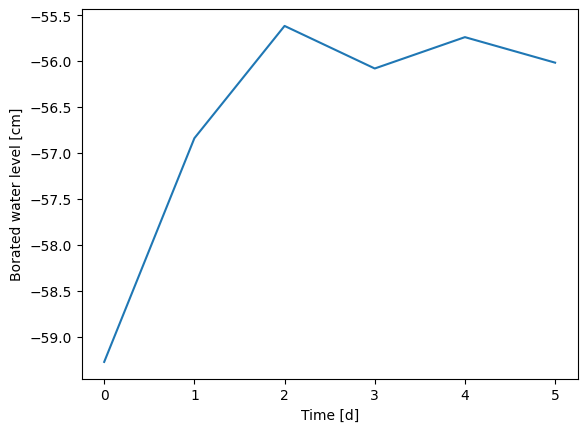

In [15]:
# Offset the values by 59cm, our initial water level height
y = [r.reac_cont - 59 for r in results]
plt.plot(time, y)
plt.xlabel("Time [d]")
plt.ylabel("Borated water level [cm]")
plt.show()